In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import kagglehub
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

#SECTION 1: DATA LOADING AND PREPROCESSING

In [ ]:


# Download latest version
path = kagglehub.dataset_download("mysarahmadbhat/lung-cancer")
path+="/survey lung cancer.csv"
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'lung-cancer' dataset.
Path to dataset files: /kaggle/input/lung-cancer/survey lung cancer.csv


In [ ]:
df = pd.read_csv(path)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
df.describe()

In [ ]:
df.dtypes

,0
GENDER,object
AGE,int64
SMOKING,int64
YELLOW_FINGERS,int64
ANXIETY,int64
PEER_PRESSURE,int64
CHRONIC DISEASE,int64
FATIGUE,int64
ALLERGY,int64
WHEEZING,int64


In [ ]:
df.isnull().sum()

In [ ]:
X = df.drop(columns='LUNG_CANCER')
Y = df['LUNG_CANCER']
Y

,LUNG_CANCER
0,YES
1,YES
2,NO
3,NO
4,NO
...,...
304,YES
305,YES
306,YES
307,YES


In [ ]:
categorical_columns = X.select_dtypes(include=['object']).columns.to_list()
categorical_columns


X_cleaned = pd.get_dummies(X, categorical_columns, dtype=int, drop_first=False)
Y_cleaned = (Y.astype(str).str.strip().str.upper() == "YES").astype(int)
df_cleaned = X_cleaned.join(Y_cleaned)

In [ ]:
(Y_cleaned ==0).sum()

np.int64(39)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, Y_cleaned, test_size=0.3, random_state=42, shuffle=False)

In [ ]:
#for classification no need to scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#SECTION 2: NO FEATURE SELECTION/EXTRACTION

#SECTION 2.1: MODEL CREATION

Logistic Regression

In [ ]:
model = LogisticRegression(class_weight='balanced', max_iter=500)
model.fit(X_train_scaled, y_train)
y_predicted = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_predicted) * 100
cm = confusion_matrix(y_test, y_predicted)
print(f"Logistic Regression model accuracy: {acc:.2f}%")
print(classification_report(y_test, y_predicted))

Logistic Regression model accuracy: 92.47%
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.97      0.94      0.96        81

    accuracy                           0.92        93
   macro avg       0.82      0.89      0.85        93
weighted avg       0.93      0.92      0.93        93



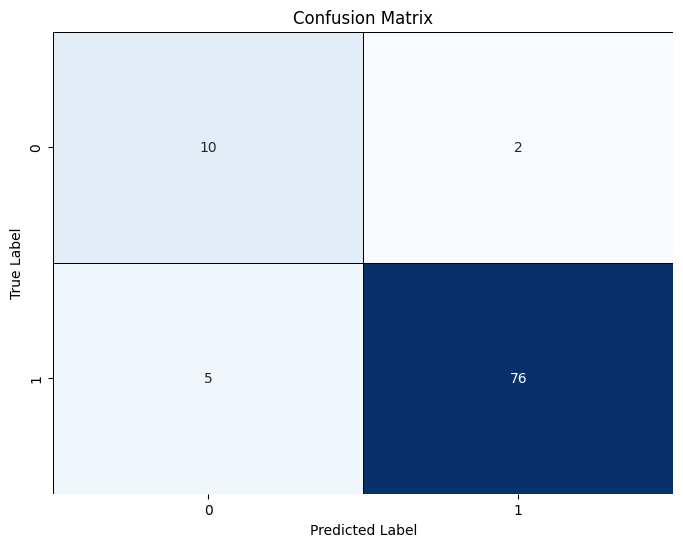

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                linewidths=.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Support Vector Machine

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt

svm = SVC(kernel="rbf", C=0.1, gamma='scale', class_weight='balanced')
svm.fit(X_train_scaled, y_train)
y_svm = svm.predict(X_test_scaled)
acc = accuracy_score(y_test, y_svm) * 100
cm_svm = confusion_matrix(y_test, y_svm)
print(f"SVM model accuracy: {acc:.2f}%")
print(classification_report(y_test, y_svm))

SVM model accuracy: 93.55%
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.97      0.95      0.96        81

    accuracy                           0.94        93
   macro avg       0.84      0.89      0.87        93
weighted avg       0.94      0.94      0.94        93



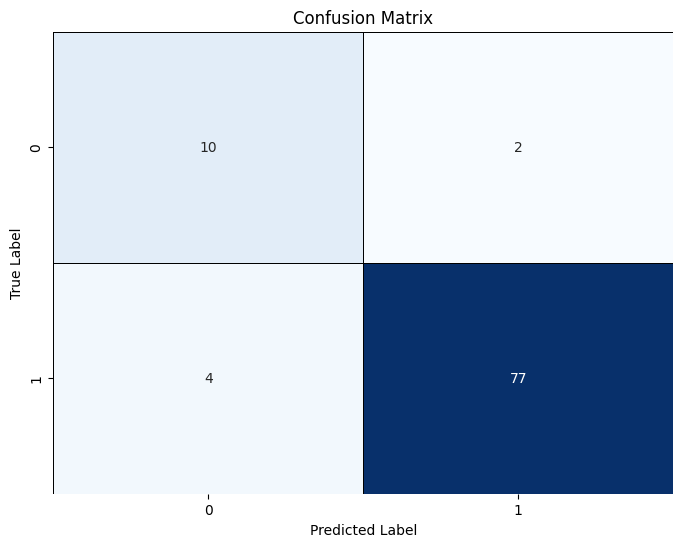

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
                linewidths=.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

With SMOTE sampling

In [ ]:
# Apply SMOTE on the scaled TRAIN set
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Train SVM
svm2 = SVC(kernel="rbf", C=0.1, gamma='scale', class_weight='balanced')
svm2.fit(X_train_resampled, y_train_resampled)

# Predict using the correct model AND scaled test data
y_smote = svm2.predict(X_test_scaled)

# Evaluate
acc = accuracy_score(y_test, y_smote) * 100
cm_svm = confusion_matrix(y_test, y_smote)
print(f"SVM model accuracy: {acc:.2f}%")
print(classification_report(y_test, y_smote))


SVM model accuracy: 92.47%
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.97      0.94      0.96        81

    accuracy                           0.92        93
   macro avg       0.82      0.89      0.85        93
weighted avg       0.93      0.92      0.93        93



Random Forest Classifier

In [ ]:
classifier = rf(n_estimators=100, random_state=42)
classifier.fit(X_train_scaled, y_train)
y_random = classifier.predict(X_test_scaled)
acc = accuracy_score(y_test, y_random) * 100
cm_random = confusion_matrix(y_test, y_random)
print(f"SVM model accuracy: {acc:.2f}%")
print(classification_report(y_test, y_random))

SVM model accuracy: 93.55%
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.94      0.99      0.96        81

    accuracy                           0.94        93
   macro avg       0.91      0.79      0.83        93
weighted avg       0.93      0.94      0.93        93



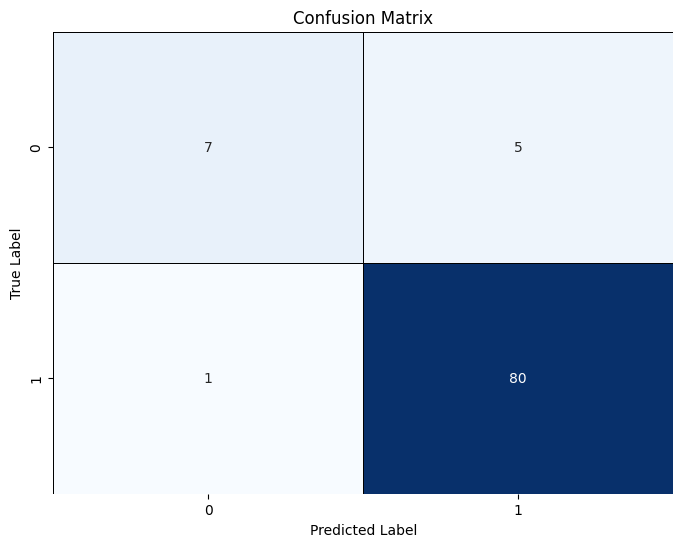

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', cbar=False,
                linewidths=.5, linecolor='black')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#SECTION 2.2: GRAPH COMPARISON

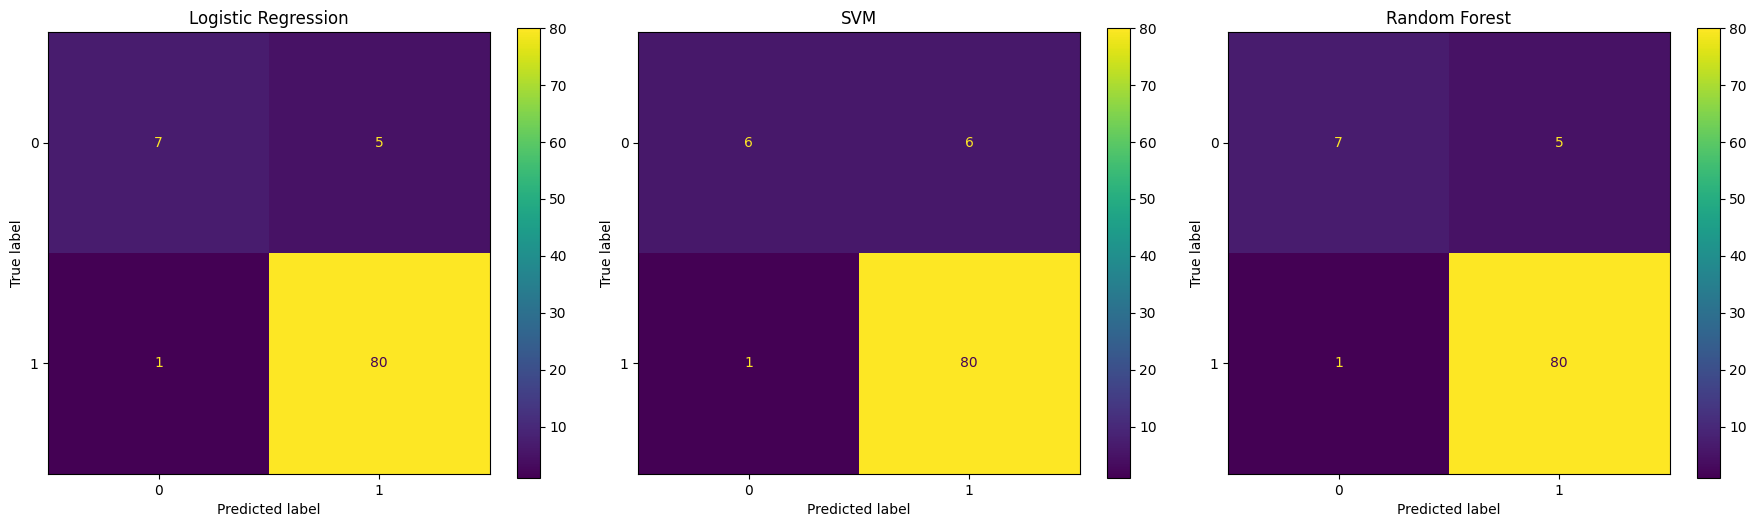

In [ ]:
from sklearn.linear_model import LogisticRegression # Ensure LogisticRegression class is available
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as rf # Re-import rf for consistency

svm = SVC(kernel='rbf', probability=True)
# Use LogisticRegression directly to avoid potential conflicts with the 'logreg' alias being overwritten
logreg_plot_model = LogisticRegression(max_iter=1000)
classifier = rf(n_estimators=100, random_state=42)

models = {
    "Logistic Regression": logreg_plot_model,
    "SVM": svm,
    "Random Forest": classifier, # Re-add Random Forest model
}

# Adjust subplot creation based on the number of models
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))

# Ensure axes is always iterable, even for a single subplot
if len(models) == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, ax=axes[i]
    )
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

#SECTION 3: WITH FEATURE SELECTION

**Multicollinearity**

Multicollinearity is a statistical issue in regression models where two or more independent variables are highly correlated, making it difficult to determine their individual effects on the dependent variable, leading to unstable coefficient estimates, inflated standard errors, and unreliable model interpretation, even if the overall model predicts well.

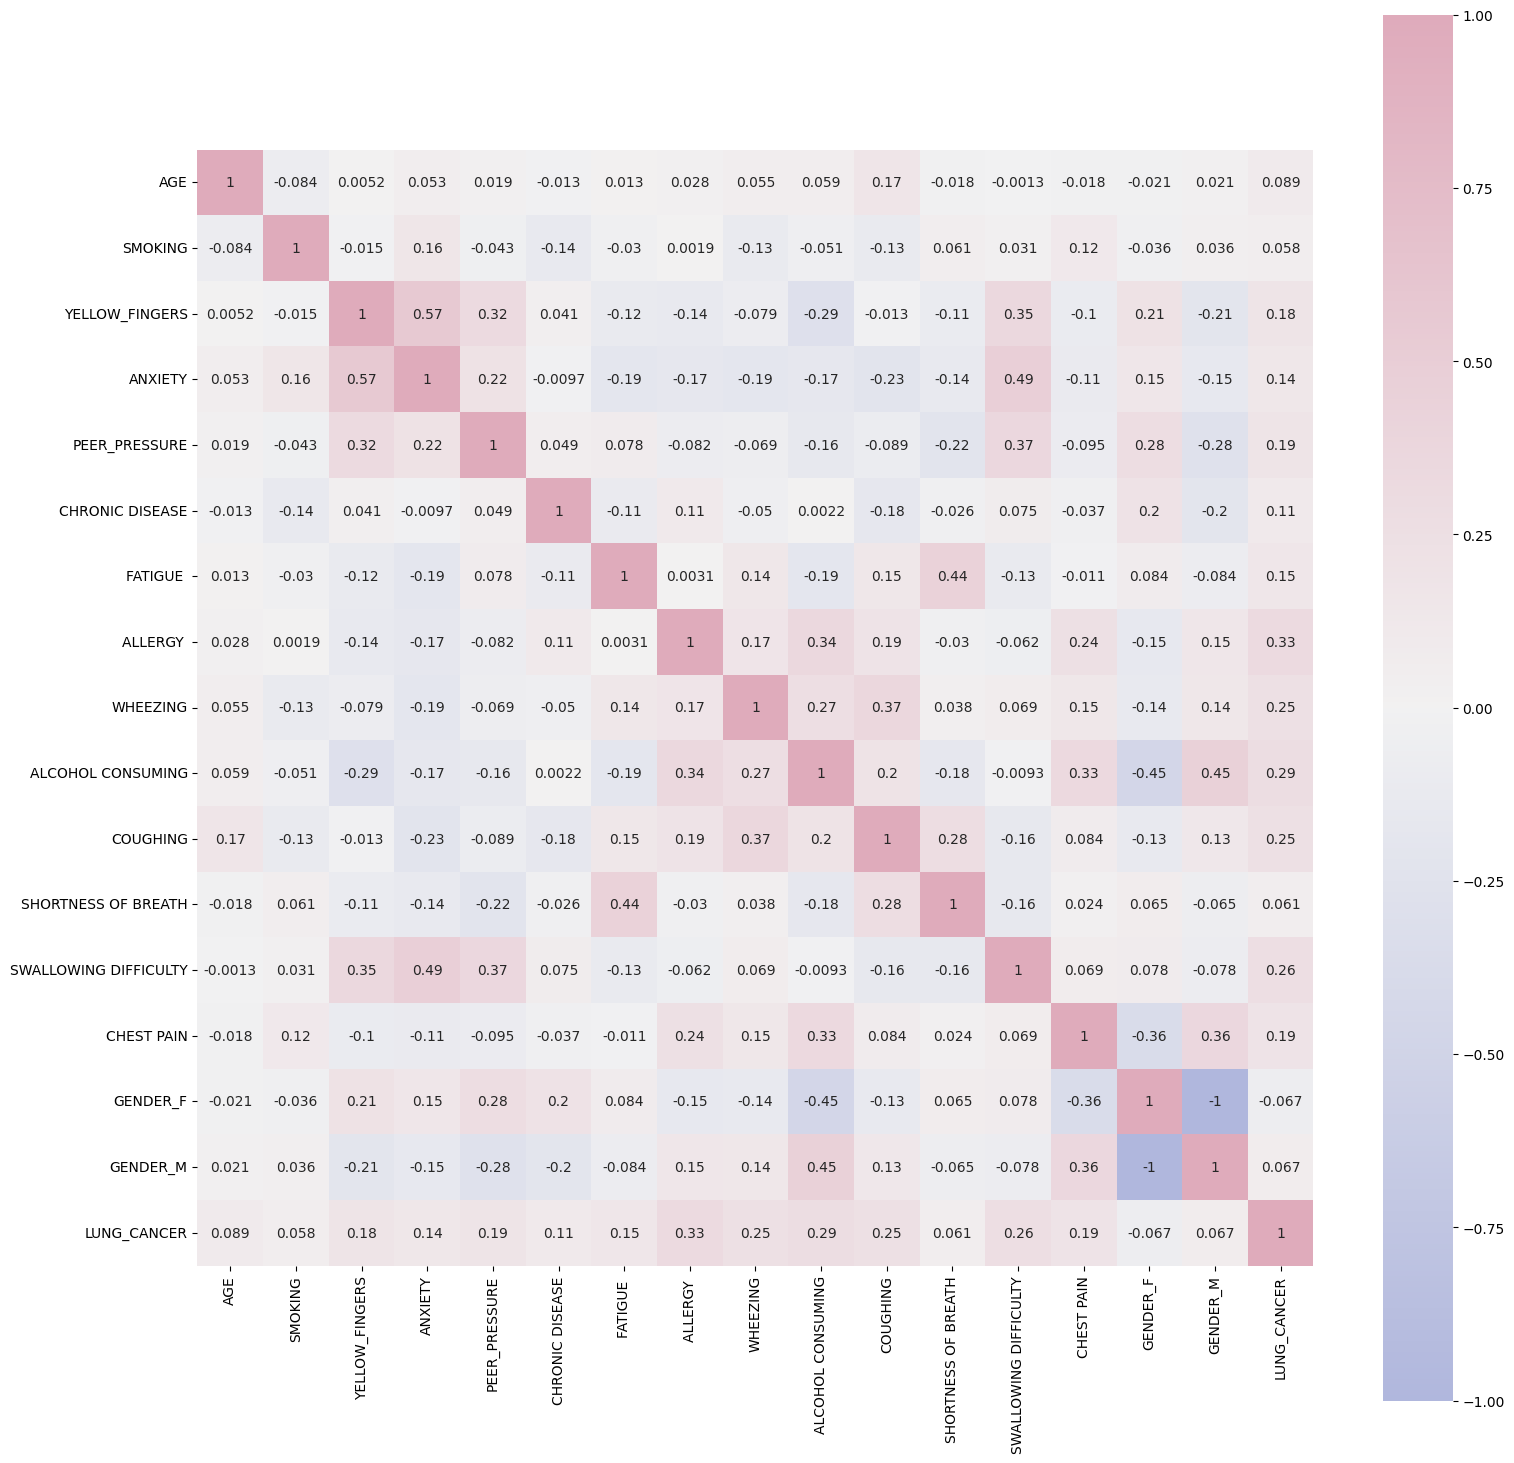

In [ ]:
#check feature correlation

cn=df_cleaned.corr()
cmap=sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(cn,cmap=cmap,annot=True, square=True)
plt.show()

<Axes: >

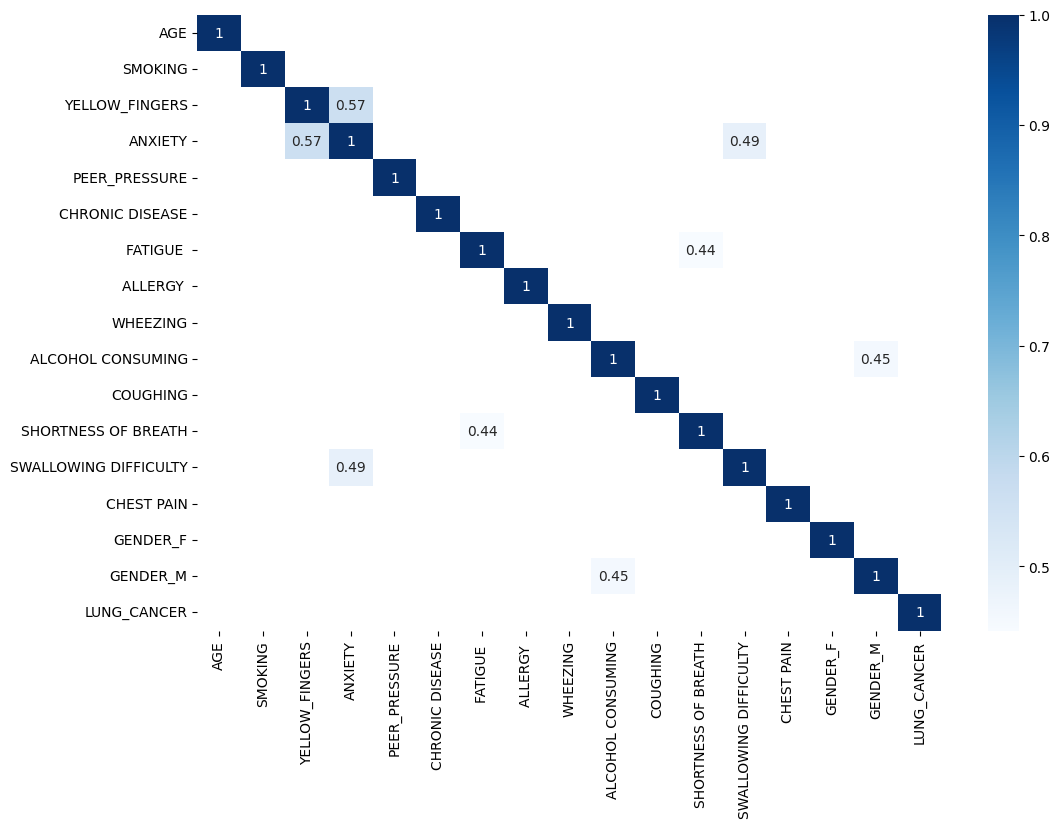

In [ ]:
#anxiety and yellow fingers and anxiety and swallowing difficulty are correlated
above = cn[cn>.40]
plt.figure(figsize=(12,8))
sns.heatmap(above, cmap="Blues", annot=True)

Feature Creation w/o PCA

In [ ]:
df_copy = df_cleaned.copy()

In [ ]:
df_cleaned['PHYSICAL_SYMPTOMS'] = (
    0.55 * df_cleaned['YELLOW_FINGERS'] +
    0.45 * df_cleaned['SWALLOWING DIFFICULTY']
)
df_cleaned['RESPIRATORY_SYMPTOMS'] = (
    0.55 * df_cleaned['FATIGUE '] +
    0.45 * df_cleaned['SHORTNESS OF BREATH']
)
X = df_cleaned.drop(columns=['LUNG_CANCER', 'YELLOW_FINGERS', 'SWALLOWING DIFFICULTY', 'FATIGUE ', 'SHORTNESS OF BREATH'])
Y = df_cleaned['LUNG_CANCER']

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, Y_resampled = adasyn.fit_resample(X, Y)

In [ ]:
#split into training and testing sets
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, shuffle=False)

#scale the data
scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

In [ ]:
model3 = LogisticRegression(class_weight='balanced', max_iter=500)
model3.fit(Xc_train_scaled, Yc_train)
y_predicted = model3.predict(Xc_test_scaled)
acc = accuracy_score(Yc_test, y_predicted) * 100
cm = confusion_matrix(Yc_test, y_predicted)
print(f"Logistic Regression model accuracy: {acc:.2f}%")
print(classification_report(Yc_test, y_predicted))

Logistic Regression model accuracy: 94.62%
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.97      0.96      0.97        81

    accuracy                           0.95        93
   macro avg       0.87      0.90      0.88        93
weighted avg       0.95      0.95      0.95        93



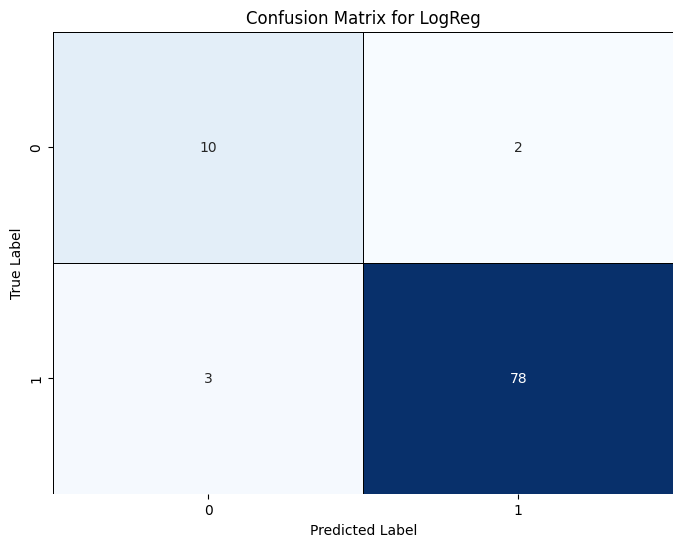

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                linewidths=.5, linecolor='black')
plt.title('Confusion Matrix for LogReg')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
svm2 = SVC(kernel="rbf", C=0.1, gamma='scale', class_weight='balanced')
svm2.fit(Xc_train_scaled, Yc_train)
y_svm = svm2.predict(Xc_test_scaled)
acc = accuracy_score(Yc_test, y_svm) * 100
cm_svm = confusion_matrix(Yc_test, y_svm)
print(f"SVM model accuracy: {acc:.2f}%")
print(classification_report(Yc_test, y_svm))

SVM model accuracy: 93.55%
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.97      0.95      0.96        81

    accuracy                           0.94        93
   macro avg       0.84      0.89      0.87        93
weighted avg       0.94      0.94      0.94        93



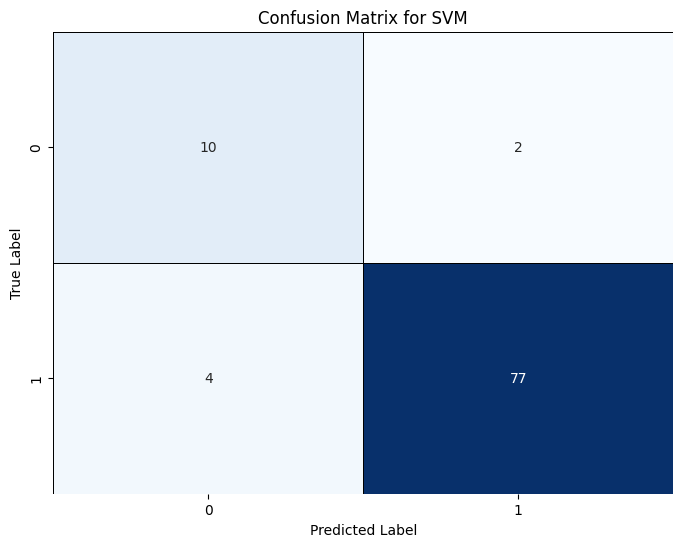

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
                linewidths=.5, linecolor='black')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Feature Creation w/ PCA

In [ ]:
features = df_copy[["ANXIETY", "YELLOW_FINGERS", "SWALLOWING DIFFICULTY"]]

pca = PCA(n_components=1)
df_copy["combined_symptom"] = pca.fit_transform(features)
X = df_copy.drop(columns=['LUNG_CANCER','ANXIETY', 'YELLOW_FINGERS', 'SWALLOWING DIFFICULTY'])
Y = df_copy['LUNG_CANCER']

In [ ]:
#split into training and testing sets
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

#scale the data
scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train)
Xc_test_scaled = scaler.transform(Xc_test)

In [ ]:
model = LogisticRegression(class_weight='balanced', max_iter=500)
model.fit(Xc_train_scaled, Yc_train)
y_predicted = model.predict(Xc_test_scaled)
acc = accuracy_score(Yc_test, y_predicted) * 100
cm = confusion_matrix(Yc_test, y_predicted)
print(f"Logistic Regression model accuracy: {acc:.2f}%")
print(classification_report(Yc_test, y_predicted))

Logistic Regression model accuracy: 94.62%
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.97      0.96      0.97        81

    accuracy                           0.95        93
   macro avg       0.87      0.90      0.88        93
weighted avg       0.95      0.95      0.95        93



**RFECV**


In [ ]:
classifier = LogisticRegression(max_iter=1000, class_weight='balanced') # Changed to LogisticRegression
# Use RFE with cross-validation to
# find the optimal number of features
selector = RFECV(classifier, cv=5)
selector = selector.fit(X_cleaned, Y_cleaned)

# Print the optimal number of features
print("Optimal number of features: %d" % selector.n_features_)

# Print the selected features
print("Selected features: %s" % selector.support_)

Optimal number of features: 12
Selected features: [False  True  True  True  True  True  True  True  True  True  True False
  True  True False False]


In [ ]:
# Select only the relevant features, using X_cleaned as selector.support_ was fitted on it
X_rfe = X_cleaned.loc[:, selector.support_]

# Define the estimator
estimator = LogisticRegression(class_weight='balanced', max_iter=1000)

Xr_train, Xr_test, Yr_train, Yr_test = train_test_split(X_rfe, Y_cleaned, test_size=0.3, shuffle=False)

scaler = StandardScaler()
Xrt_scaled = scaler.fit_transform(Xr_train)
Xrtest_scaled = scaler.transform(Xr_test)

# Train the final model using the
# selected features
estimator.fit(Xrt_scaled, Yr_train) # Changed Y_cleaned to Yr_train
y_predicted = estimator.predict(Xrtest_scaled)
acc = accuracy_score(Yr_test, y_predicted) * 100
cm = confusion_matrix(Yr_test, y_predicted)
print(f"Logistic Regression model accuracy: {acc:.2f}%")
print(classification_report(Yr_test, y_predicted))

Logistic Regression model accuracy: 91.40%
              precision    recall  f1-score   support

           0       0.62      0.83      0.71        12
           1       0.97      0.93      0.95        81

    accuracy                           0.91        93
   macro avg       0.80      0.88      0.83        93
weighted avg       0.93      0.91      0.92        93

